In [1]:
import numpy as np
import time
# np.seterr(all='raise')
np.seterr(under='ignore', invalid='raise', divide='raise', over='raise')
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kv  # K_v BESSEL FUNCTIONS
from scipy.special import zeta, polygamma, factorial
import matplotlib as mpl
from mpmath import zeta
from itertools import cycle
from scipy.special import kve


from functions import *

from xsec_expressions import *


mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})

In [2]:
def make_params(mchi, mA, alphaD, eps, gchi = 2, gA = 3):
    return {
        "mchi": mchi, "mA": mA,
        "alphaD": alphaD, "epsilon": eps,
        "sv_xxAA": sigma_xx_to_AA(alphaD, mchi, mA),
        "sv_xxee": sigmav_chichi_ee(eps, alphaD, mchi, mA),
        "gamma_Aee": gammaA_ee(eps, mA),
        "t_dep": True, "gchi": gchi, "gA": gA,
    }

def update_alphaD(params, new_alphaD):
    new_params = params.copy()
    new_params["alphaD"] = new_alphaD
    new_params["sv_xxAA"] = sigma_xx_to_AA(new_alphaD, params["mchi"], params["mA"])
    new_params["sv_xxee"] = sigmav_chichi_ee(params["epsilon"], new_alphaD, params["mchi"], params["mA"])
    return new_params

def update_alphaD_and_eps(params, new_alphaD, new_epsilon):
    new_params = params.copy()
    new_params["alphaD"] = new_alphaD
    new_params["epsilon"] = new_epsilon
    new_params["sv_xxAA"] = sigma_xx_to_AA(new_alphaD, params["mchi"], params["mA"])
    new_params["sv_xxee"] = sigmav_chichi_ee(new_epsilon, new_alphaD, params["mchi"], params["mA"])
    new_params["gamma_Aee"] = gammaA_ee(new_epsilon, params["mA"])
    return new_params


In [37]:
OMEGA_TARGET = 0.12

def omega_of_params(params, xs, ic):
    out = evolve(params, x_initial=xs[0], x_final=xs[-1], y0=ic, xs=xs, log_space=True, rtol=1e-5, atol=1e-10)
    sol = out["sol"]; x_arr = out["x_arr"]
    nchi, nA, Th = sol
    T  = params["mchi"] / x_arr
    Yx = Y(np.asarray(nchi), T)
    omega = get_relic_abundance(Yx[-1], params["mchi"])

    # freeze-out locator
    diag = compute_diagnostics(x_arr, sol, params)
    ixf = np.argmin(np.abs(diag["Gamma_chem_over_H"] - 1.0))
    success = np.isfinite(omega) and (diag["Gamma_chem_over_H"][0] > 10)

    return omega, {"success": success, "x_f": x_arr[ixf], "diag": diag}


def solve_alphaD_for_target(params, xs, ic, u_lo=-7.0, u_hi=-2.0, tol=0.05, maxit=40):
    def F(u):
        #p = dict(params); p["alphaD"] = 10.0**u
        #p = params.copy(); p["alphaD"] = 10.0**u
        #p = make_params(params)
        p = update_alphaD(params, 10.0**u)
        print(p)
        omega, meta = omega_of_params(p, xs, ic)
        print("alphaD = %.3e -> omega = %.3e (target %.3e)" % (p["alphaD"], omega, OMEGA_TARGET))
        return omega/OMEGA_TARGET - 1.0, meta

    f_lo, meta_lo = F(u_lo); f_hi, meta_hi = F(u_hi)
    if f_lo < 0: u_lo, u_hi, f_lo, f_hi = u_hi, u_lo, f_hi, f_lo # ensure f_lo > 0, f_hi < 0

    for _ in range(maxit):
        u_mid = 0.5*(u_lo + u_hi)
        f_mid, meta_mid = F(u_mid)
        if not meta_mid["success"]:
            u_hi = u_mid; f_hi = f_mid; continue
        if abs(f_mid) <= tol:
            return 10.0**u_mid, meta_mid
        if f_mid > 0:   # if omega too large then alphaD too small
            u_lo, f_lo = u_mid, f_mid
        else:
            u_hi, f_hi = u_mid, f_mid
    return 10.0**u_mid, meta_mid


def scan_grid(alpha_grid, eps_grid, params, xs, ic):
    Omega = np.full((len(alpha_grid), len(eps_grid)), np.nan)
    dom   = np.zeros_like(Omega, dtype=int)  # 0=bad, 1=AA, 2=SM
    for i, a in enumerate(alpha_grid):
        for j, e in enumerate(eps_grid):
            #p = dict(params); p["alphaD"]=a; p["epsilon"]=e
            p = update_alphaD_and_eps(params, a, e)

            omega, meta = omega_of_params(p, xs, ic=ic)
            if not meta["success"]: continue
            Omega[i,j] = omega
            d = meta["diag"]
            aa = d["Gamma_xAA_over_H"][np.argmin(np.abs(d["x"]-meta["x_f"]))]
            sm = d["Gamma_xSM_over_H"][np.argmin(np.abs(d["x"]-meta["x_f"]))]
            dom[i,j] = 1 if aa>sm else 2
            print("alphaD=%.3e, eps=%.3e -> Omega=%.3e, dom=%d" % (a, e, omega, dom[i,j]))
    return Omega, dom

In [6]:
alpha = 1.2e-4
epsilon =  3e-6
mchi = 10 # 0.3
mA = 8 # 0.3*0.7
gchi = 2
gA = 3


params = make_params(mchi, mA, alpha, epsilon)
x_i, x_f = 1.0, 400.0
T_i = mchi / x_i

Th_i = T_i
nchi_i = neq(mchi, gchi, Th_i)
nA_i  = neq(mA,  gA,  Th_i)
y0 = np.array([nchi_i, nA_i, Th_i])
xs  = np.geomspace(x_i, x_f, 1000)

# alphaD_sol, meta = solve_alphaD_for_target(params, xs, ic = y0, u_lo=-5.0, u_hi=-3.0, tol=0.01, maxit=30)

In [ ]:
# alpha, epsilon
out_scan = scan_grid(np.logspace(-10, -6, 6), np.logspace(-15, -9, 6), params, xs, y0)

alphaD=1.000e-10, eps=1.000e-15 -> Omega=1.560e+06, dom=1
alphaD=1.000e-10, eps=1.585e-14 -> Omega=1.560e+06, dom=1
alphaD=1.000e-10, eps=2.512e-13 -> Omega=1.560e+06, dom=1
alphaD=1.000e-10, eps=3.981e-12 -> Omega=1.560e+06, dom=1
alphaD=1.000e-10, eps=6.310e-11 -> Omega=1.560e+06, dom=1
alphaD=1.000e-10, eps=1.000e-09 -> Omega=1.560e+06, dom=1
alphaD=6.310e-10, eps=1.000e-15 -> Omega=1.555e+06, dom=1
alphaD=6.310e-10, eps=1.585e-14 -> Omega=1.555e+06, dom=1
alphaD=6.310e-10, eps=2.512e-13 -> Omega=1.555e+06, dom=1
alphaD=6.310e-10, eps=3.981e-12 -> Omega=1.555e+06, dom=1
alphaD=6.310e-10, eps=6.310e-11 -> Omega=1.555e+06, dom=1
alphaD=6.310e-10, eps=1.000e-09 -> Omega=1.555e+06, dom=1
alphaD=3.981e-09, eps=1.000e-15 -> Omega=1.404e+06, dom=1
alphaD=3.981e-09, eps=1.585e-14 -> Omega=1.404e+06, dom=1
alphaD=3.981e-09, eps=2.512e-13 -> Omega=1.404e+06, dom=1
alphaD=3.981e-09, eps=3.981e-12 -> Omega=1.404e+06, dom=1
alphaD=3.981e-09, eps=6.310e-11 -> Omega=1.404e+06, dom=1
alphaD=3.981e-

In [16]:
out_scan3 = scan_grid(np.logspace(-14, -10, 6), np.logspace(-7, -2, 6), params, xs, y0)

alphaD=1.000e-14, eps=1.000e-07 -> Omega=1.560e+06, dom=1
alphaD=1.000e-14, eps=1.000e-06 -> Omega=1.560e+06, dom=2
alphaD=1.000e-14, eps=1.000e-05 -> Omega=1.560e+06, dom=2
alphaD=1.000e-14, eps=1.000e-04 -> Omega=1.560e+06, dom=2
alphaD=1.000e-14, eps=1.000e-03 -> Omega=1.560e+06, dom=2
alphaD=1.000e-14, eps=1.000e-02 -> Omega=1.559e+06, dom=2
alphaD=6.310e-14, eps=1.000e-07 -> Omega=1.560e+06, dom=1
alphaD=6.310e-14, eps=1.000e-06 -> Omega=1.560e+06, dom=1
alphaD=6.310e-14, eps=1.000e-05 -> Omega=1.560e+06, dom=2
alphaD=6.310e-14, eps=1.000e-04 -> Omega=1.560e+06, dom=2
alphaD=6.310e-14, eps=1.000e-03 -> Omega=1.560e+06, dom=2
alphaD=6.310e-14, eps=1.000e-02 -> Omega=1.558e+06, dom=2
alphaD=3.981e-13, eps=1.000e-07 -> Omega=1.560e+06, dom=1
alphaD=3.981e-13, eps=1.000e-06 -> Omega=1.560e+06, dom=1
alphaD=3.981e-13, eps=1.000e-05 -> Omega=1.560e+06, dom=2
alphaD=3.981e-13, eps=1.000e-04 -> Omega=1.560e+06, dom=2
alphaD=3.981e-13, eps=1.000e-03 -> Omega=1.560e+06, dom=2
alphaD=3.981e-

In [19]:
out_scan4 = scan_grid(np.logspace(-10, -6, 6), np.logspace(-3, -2, 6), params, xs, y0)

alphaD=1.000e-10, eps=1.000e-03 -> Omega=1.542e+06, dom=2
alphaD=1.000e-10, eps=1.585e-03 -> Omega=1.515e+06, dom=2
alphaD=1.000e-10, eps=2.512e-03 -> Omega=1.454e+06, dom=2
alphaD=1.000e-10, eps=3.981e-03 -> Omega=1.322e+06, dom=2
alphaD=1.000e-10, eps=6.310e-03 -> Omega=1.084e+06, dom=2
alphaD=1.000e-10, eps=1.000e-02 -> Omega=7.700e+05, dom=2
alphaD=6.310e-10, eps=1.000e-03 -> Omega=1.449e+06, dom=2
alphaD=6.310e-10, eps=1.585e-03 -> Omega=1.317e+06, dom=2
alphaD=6.310e-10, eps=2.512e-03 -> Omega=1.082e+06, dom=2
alphaD=6.310e-10, eps=3.981e-03 -> Omega=7.688e+05, dom=2
alphaD=6.310e-10, eps=6.310e-03 -> Omega=4.779e+05, dom=2
alphaD=6.310e-10, eps=1.000e-02 -> Omega=2.707e+05, dom=2
alphaD=3.981e-09, eps=1.000e-03 -> Omega=9.838e+05, dom=2
alphaD=3.981e-09, eps=1.585e-03 -> Omega=7.239e+05, dom=2
alphaD=3.981e-09, eps=2.512e-03 -> Omega=4.633e+05, dom=2
alphaD=3.981e-09, eps=3.981e-03 -> Omega=2.668e+05, dom=2
alphaD=3.981e-09, eps=6.310e-03 -> Omega=1.427e+05, dom=2
alphaD=3.981e-

In [29]:
out_scan5 = scan_grid(np.logspace(-6, -3, 4), np.logspace(-10, -5, 8), params, xs, y0)

alphaD=1.000e-06, eps=1.000e-10 -> Omega=1.374e+03, dom=1
alphaD=1.000e-06, eps=5.179e-10 -> Omega=1.351e+03, dom=1
alphaD=1.000e-06, eps=2.683e-09 -> Omega=1.261e+03, dom=1
alphaD=1.000e-06, eps=1.389e-08 -> Omega=1.141e+03, dom=1
alphaD=1.000e-06, eps=7.197e-08 -> Omega=8.059e+02, dom=1
alphaD=1.000e-06, eps=3.728e-07 -> Omega=7.911e+02, dom=1
alphaD=1.000e-06, eps=1.931e-06 -> Omega=7.906e+02, dom=1
alphaD=1.000e-06, eps=1.000e-05 -> Omega=7.906e+02, dom=1
alphaD=1.000e-05, eps=1.000e-10 -> Omega=1.947e+01, dom=1
alphaD=1.000e-05, eps=5.179e-10 -> Omega=1.900e+01, dom=1
alphaD=1.000e-05, eps=2.683e-09 -> Omega=1.732e+01, dom=1
alphaD=1.000e-05, eps=1.389e-08 -> Omega=1.604e+01, dom=1
alphaD=1.000e-05, eps=7.197e-08 -> Omega=1.261e+01, dom=1
alphaD=1.000e-05, eps=3.728e-07 -> Omega=1.252e+01, dom=1
alphaD=1.000e-05, eps=1.931e-06 -> Omega=1.252e+01, dom=1
alphaD=1.000e-05, eps=1.000e-05 -> Omega=1.252e+01, dom=1
alphaD=1.000e-04, eps=1.000e-10 -> Omega=2.455e-01, dom=1
alphaD=1.000e-

Text(0, 0.5, '$\\log_{10} \\alpha_D$')

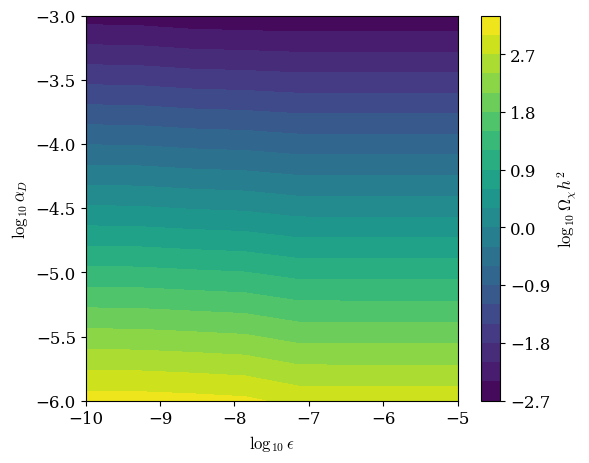

In [31]:
Omega, dom = out_scan5
# epsilon = np.logspace(-15, -9, 6)
# alphaD = np.logspace(-10, -6, 6)
# epsilon = np.logspace(-15, -8, 6)
# alphaD = np.logspace(-14, -10, 6)

# epsilon = np.logspace(-7, -2, 6)
# alphaD = np.logspace(-14, -10, 6)

# epsilon = np.logspace(-3, -2, 6)
# alphaD = np.logspace(-10, -6, 6)

epsilon = np.logspace(-10, -5, 8)
alphaD = np.logspace(-6, -3, 4)

fig, ax = plt.subplots(figsize=(6,5))
cs = ax.contourf(np.log10(np.array(epsilon)), np.log10(np.array(alphaD)), np.log10(Omega), levels=20, cmap='viridis')
cbar = fig.colorbar(cs)
cbar.set_label(r'$\log_{10} \Omega_\chi h^2$')
ax.set_xlabel(r'$\log_{10} \epsilon$')
ax.set_ylabel(r'$\log_{10} \alpha_D$')

Text(0, 0.5, '$\\log_{10} \\alpha_D$')

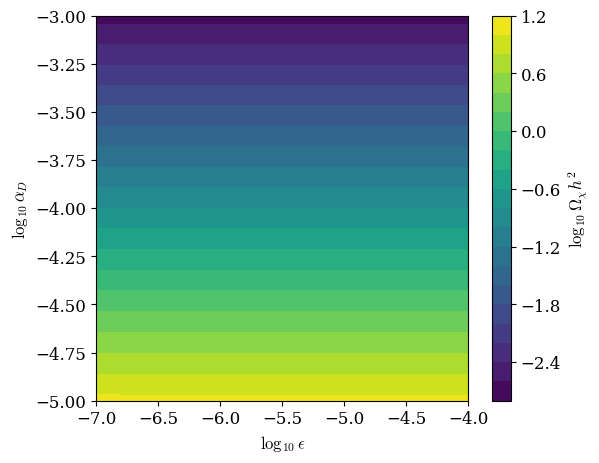

In [37]:
# plot the scan results
Omega, dom = out_scan
epsilon = np.logspace(-7, -4, 10)
alpha = np.logspace(-5, -3, 10)
fig, ax = plt.subplots(figsize=(6,5))
cs = ax.contourf(np.log10(np.array(epsilon)), np.log10(np.array(alpha)), np.log10(Omega), levels=20, cmap='viridis')
cbar = fig.colorbar(cs)
cbar.set_label(r'$\log_{10} \Omega_\chi h^2$')
ax.set_xlabel(r'$\log_{10} \epsilon$')
ax.set_ylabel(r'$\log_{10} \alpha_D$')

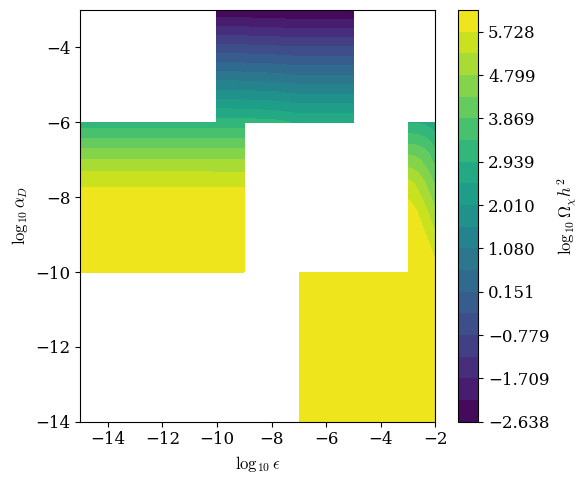

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

Omega1, _ = out_scan
Omega3, _ = out_scan3
Omega4, _ = out_scan4
Omega5, _ = out_scan5

aD1  = np.logspace(-10, -6, 6)
eps1   = np.logspace(-15, -9, 6)

aD3  = np.logspace(-14, -10, 6)
eps3  = np.logspace(-7,  -2, 6)

aD4 = np.logspace(-10, -6, 6)
eps4 = np.logspace(-3,  -2, 6)


aD5 = np.logspace(-6, -3, 4)
eps5 = np.logspace(-10, -5, 8)

# work in log10 space
logOm1 = np.log10(Omega1)
logOm3 = np.log10(Omega3)
logOm4 = np.log10(Omega4)
logOm5 = np.log10(Omega5)

# shared color scaling across all patches
vmin = min(logOm1.min(), logOm3.min(), logOm4.min(), logOm5.min())
vmax = max(logOm1.max(), logOm3.max(), logOm4.max(), logOm5.max())
levels = np.linspace(vmin, vmax, 20)
norm = Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(6, 5))

# list of (epsilon, alphaD, logOmega) patches
patches = [
    (eps1, aD1, logOm1),
    (eps3, aD3, logOm3),
    (eps4, aD4, logOm4),
    (eps5, aD5, logOm5),
]

for eps, aD, logOm in patches:
    cs = ax.contourf(
        np.log10(eps), np.log10(aD), logOm,
        levels=levels, cmap="viridis", norm=norm
    )

# colorbar from last contour, but all share same norm/levels
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label(r'$\log_{10} \Omega_\chi h^2$')

ax.set_xlabel(r'$\log_{10} \epsilon$')
ax.set_ylabel(r'$\log_{10} \alpha_D$')

plt.tight_layout()
plt.show()


In [39]:
out_scan6 = scan_grid(np.logspace(-7, -4, 6), np.logspace(-2, 0, 4), params, xs, y0)

KeyboardInterrupt: 

In [ ]:
# full grid run : alpha in (-7, -3), eps in (-10, 0)

In [ ]:
import numpy as np

OMEGA_TARG = 0.12
DELTA_OMEGA = 0.01 * OMEGA_TARG   # tolerance
EPS_MIN, EPS_MAX = 1e-9, 1e-1    # initial bracket for epsilon
ALPHAS = np.logspace(np.log10(1.2e-4), -3, 4)  # sweep for alpha_D

def omega_for(alphaD, epsilon, base_params, xs, ic):
    params = update_alphaD_and_eps(base_params, alphaD, epsilon)
    out = evolve(params, x_initial=xs[0], x_final=xs[-1], y0=ic, xs=xs, log_space=True)
    Ychi_final = Y(out["sol"][0, -1], params["mchi"]/out["x_arr"][-1])

    y = get_relic_abundance(Ychi_final, params["mchi"])
    print("alphaD=%.3e, eps=%.3e ->yield =%.3e" % (alphaD, epsilon, y))
    return y, out

def find_eps_for(alphaD, base_params, xs, ic, eps_lo=EPS_MIN, eps_hi=EPS_MAX, last_good=None):
    # if last_good is not None:
    #     c = last_good
    #     # build a small bracket around it
    #     eps_lo, eps_hi = max(EPS_MIN, c/10), min(EPS_MAX, c*10)

    def F(eps):
        Omega, diag = omega_for(alphaD, eps, base_params, xs, ic)
        return Omega - OMEGA_TARG, diag

    # \bracket
    f_lo, d_lo = F(eps_lo)
    f_hi, d_hi = F(eps_hi)
    expand = 0
    while np.sign(f_lo) == np.sign(f_hi) and expand < 6:
        if f_lo > 0 and f_hi > 0:
            eps_lo, eps_hi = eps_hi, min(10*eps_hi, 1e-2)
        else:
            eps_hi, eps_lo = eps_lo, max(eps_lo/10, 1e-16)
        f_lo, d_lo = F(eps_lo)
        f_hi, d_hi = F(eps_hi)
        expand += 1
    if np.sign(f_lo) == np.sign(f_hi):
        return None, None  # no solution in search box

    # Bisection in log-space
    lo, hi = np.log10(eps_lo), np.log10(eps_hi)
    best = None
    for _ in range(60):
        mid = 0.5*(lo + hi)
        f_mid, d_mid = F(10**mid)
        best = (10**mid, f_mid, d_mid)
        if abs(f_mid) < DELTA_OMEGA or (hi - lo) < 1e-3:
            break
        if np.sign(f_mid) == np.sign(f_lo):
            lo, f_lo = mid, f_mid
        else:
            hi = mid
    eps_star = best[0]
    return eps_star, best[2]  # (epsilon*, diagnostics)


base_params = make_params(mchi=10, mA=8, alphaD=1.2e-4, eps=1e-6)
pairs = []
last_eps = None
for aD in ALPHAS:
    print("starting scan for alphaD = %.3e" % aD)
    eps_star, diag = find_eps_for(aD, base_params, xs, y0, last_good=last_eps)
    if eps_star is not None:
        pairs.append((aD, eps_star))
        last_eps = eps_star
# plot line from pairs


starting scan for alphaD = 1.200e-04


KeyboardInterrupt: 